<a href="https://colab.research.google.com/github/morganLantrade/Projets_machine_learning/blob/main/Projet_anti-spam/projet_anti-spam_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet : Classificateur Naïf Bayésien : Anti-spam


#### Par Lantrade Morgan et Courderc-Lafont Enguerran

#### Importations

In [1]:
import sklearn
import math
import re
import string
import warnings

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')

# 1.Première analyse des données

In [2]:
! git clone "https://github.com/morganLantrade/Projets_machine_learning.git"


fatal: destination path 'Projets_machine_learning' already exists and is not an empty directory.


In [3]:
data=pd.read_csv('/content/Projets_machine_learning/Projet_anti-spam/spam.csv')
print(data.columns)
data.head()

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


##### Regardons la répartition des spams et hams pour avoir un aperçu 

Nombre de spams : 1499  
Nombre de hams 3672
Total : 5171
Proportion de Spam/Ham = 0.29 | 0.71


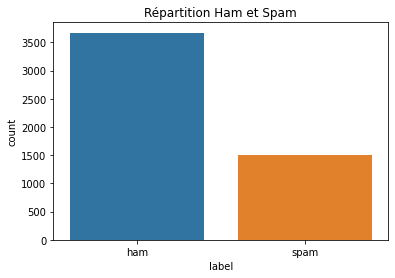

In [4]:
def afficherRepartition(data):
    '''Affiche la répartition des spams et hams de nos donnés'''
    total_spam=data[data.label_num==1]
    total_ham=data[data.label_num==0]
    n_spam= total_spam.shape[0]
    n_ham= total_ham.shape[0]
    n_total= n_ham+n_spam
    p_s=round(n_spam/n_total,2)
    p_h=round(n_ham/n_total,2)
    #Affichage
    plt.figure()
    sns.countplot(x=data['label'])
    plt.title('Répartition Ham et Spam')
    print(f'Nombre de spams : {n_spam}  \nNombre de hams {n_ham}\nTotal : {n_total}\nProportion de Spam/Ham = {p_s} | {p_h}')
    

afficherRepartition(data)


##### Affichons quelques spams pour avoir une idée de nos données.

In [5]:
def afficherNSpam(data,n) :
    '''Affiche les n premiers spams de nos données'''
    s=data[data.label_num==1]
    for i in range(n):
        print("---------------------------------------------------")
        print(s.text[s.index[i]])
        print("---------------------------------------------------")
cpt=10
afficherNSpam(data,cpt)


    

---------------------------------------------------
Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin

---------------------------------------------------
---------------------------------------------------
Subject: looking for medication ? we ` re the best source .
it is difficult to make our material condition better by the best law , but it is easy enough to ruin it by bad laws .
excuse me . . . : ) you just found the
best and simpliest site for
medication on the net . no perscription , easy
delivery .
private , secure , and easy .
better see rightly on a pound a week than squint on a million .
we ` ve got
anything that you will ever w

# 2.Prétraitement des données

### A) Construisons notre vocabulaire

In [6]:
def vocabulaire_mail(mail,n=3) :
    '''Retourne l'ensemble du vocabulaire en minisucule 
    du mail composé seulement de mots de longueur strictement supérieure à n'''
    #ne gardons que les caractères alphanumériques
    mots = re.split(r'\W+', mail)
    #ensemble en minuscule   
    return set([mot.lower() for mot in mots if len(mot)>n]) 


def vocabulaire_distribution(df) :
    '''Retourne un dictionnaire de la distribution des mots selon les classes 
    de nos données (spam ou ham )''' 
    distribution= {}
    for mail,spam in zip(df.text,df.label_num):
        vocabulaire=vocabulaire_mail(mail)
        for mot in vocabulaire:
            if mot not in distribution:
                distribution[mot]= (spam,1-spam)
            else:
                s,h=distribution[mot]
                distribution[mot]=(s+spam,h+1-spam)
    return distribution       

def df_distribution(df) :
    '''Retourne un dataframe à partir du vocabulaire de distribution''' 
    distribution=vocabulaire_distribution(df)
    vocabulaire,NSpam,NHam=[],[],[]
    for mot in distribution:
        s,h=distribution[mot]
        vocabulaire.append(mot)
        NSpam.append(s)
        NHam.append(h)
    return pd.DataFrame({'spam' : NSpam,'ham' : NHam },index=vocabulaire)


D=df_distribution(data)
nb_mots,_=D.shape
print(f'On a donc un dataframe de la distribution du vocabulaire qui est composé {nb_mots} mots.')
D.head(5)


On a donc un dataframe de la distribution du vocabulaire qui est composé 46081 mots.


,spam,ham
data,38,101
methanol,0,52
daren,0,1030
enron,0,1462
asap,3,66


Nous allons ensuite devoir vectoriser nos données selon ce vocabulaire pour qu'elles soient utilisables par les différents modèles d'apprentissage que nous allons mettre en place.
Malheureusement, utiliser un vecteur de 46 081 variables pour chaque mail de notre échantillon nous demanderais trop de calculs et ne serait peut être pas pertinent. Nous allons donc devoir faire un choix sur comment déterminer le vocabulaire que nous allons utiliser pour nos modèles d'apprentissage.

### B) Réduction de notre vocabulaire par les statistiques et probabilités

Dans les différents classifieurs probabilistes, il est souvent nécessaire d'utiliser un lissage, qui est une technique qui vise à ajuster l'estimation du maximimum de vraisemblance dans le but de corriger des imprécisions dûes à la rareté de certaines données. En effet, comme nous allons supposer que nos variables aléatoires sont indépendantes, nous allons multiplier un grand nombre de probabilités entre elles et donc ne souhaitons pas avoir de probabilités nulles.
Il existe différents types de lissage, pour notre modèle on utilisera le lissage de Laplace qui est aussi utilisé par Sklearn.

In [7]:
def lissage_Laplace(nb_Xi_Y,total_Y,nb_Y,alpha=1) :
    '''Retourne l'estimation du taux de xi dans Y avec un lissage de Laplace ( hyper paramètre alpha par défaut vaut 1)'''
    return (nb_Xi_Y+alpha)/(total_Y+alpha*nb_Y)
#On pourrait voir se lissage comme le fait d'ajouter 
#un ham et un spam contenant tous les mots du vocabulaire dans nos données.

In [8]:
def df_proba(Xa):
    '''Retourne un dataframe de la distribution et 
    des taux de nos données avec lissage de Laplace''' 
    D=df_distribution(Xa)
    total_ham,total_spam=Xa.label_num.value_counts()
    total_mail=total_ham+total_spam
    lg_V=len(D.index)
    diff,taux_M,taux_M_S,taux_M_H,taux_S_M,taux_H_M=[],[],[],[],[],[]
    for mot in D.index:
        #distribution
        n_spam,n_ham =D.spam[mot],D.ham[mot]
        #Taux de Y
        t_spam=total_spam/total_mail
        t_ham=total_ham/total_mail
        #Taux de xi sachant Y avec Lissage de Laplace
        t_mot_spam = lissage_Laplace(n_spam,total_spam,2)
        t_mot_ham = lissage_Laplace(n_ham,total_ham,2)
        #Taux de xi
        t_mot= (n_spam+n_ham)/total_mail
        #Taux de Y sachant Xi Bayes Theorem 
        t_spam_mot= (t_mot_spam*t_spam)/(t_mot_spam*t_spam+t_mot_ham*t_ham)
        t_ham_mot= (t_mot_ham*t_ham)/(t_mot_spam*t_spam+t_mot_ham*t_ham)
        #maj resultat
        taux_M.append(t_mot)
        taux_M_S.append(t_mot_spam)
        taux_M_H.append(t_mot_ham)
        taux_S_M.append(t_spam_mot)
        taux_H_M.append(t_ham_mot)
        diff.append(abs(t_spam_mot-t_ham_mot))
    return pd.DataFrame({'spam' : D.spam,'ham' : D.ham,'t(mot)': taux_M ,'t(mot|spam)' : taux_M_S,'t(mot|ham)' : taux_M_H ,'t(spam|mot)' : taux_S_M,'t(ham|mot)' : taux_H_M,'diff': diff},index=D.index)


def afficherDiff(Xa,taux):
    '''Affiche la différence en valeur absolue de P(ham|mot)-P(spam|mot) 
    selon le taux de différence souhaité'''
    V_proba=df_proba(Xa)
    V_proba=V_proba.sort_values(by=['diff'],ascending=False)
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(14)
    V0=list(range(V_proba.index.size))
    V1=list(range(V_proba[(V_proba['diff']>taux)].index.size))
    D0=np.array(V_proba['diff'])
    D1=np.array(V_proba[(V_proba['diff']>taux)]['diff'])
    axs[0].plot(V0,D0,label='|P(spam|mot)-P(ham|mot)|')
    axs[0].set_title('Différence absolue entre P(spam|mot) et P(ham|mot)')
    axs[0].legend()
    axs[1].plot(V1,D1,label='|P(spam|mot)-P(ham|mot)|')
    axs[1].set_title(f'Différence absolue entre P(spam|mot) et P(ham|mot) > {taux}')
    axs[1].legend()




In [9]:
V_proba=df_proba(data)
V_proba.head(5)

,spam,ham,t(mot),t(mot|spam),t(mot|ham),t(spam|mot),t(ham|mot),diff
data,38,101,0.026881,0.025983,0.027763,0.276438,0.723562,0.447124
methanol,0,52,0.010056,0.000666,0.014426,0.018504,0.981496,0.962992
daren,0,1030,0.199188,0.000666,0.280621,0.000968,0.999032,0.998064
enron,0,1462,0.282731,0.000666,0.398204,0.000683,0.999317,0.998635
asap,3,66,0.013344,0.002665,0.018236,0.056296,0.943704,0.887408


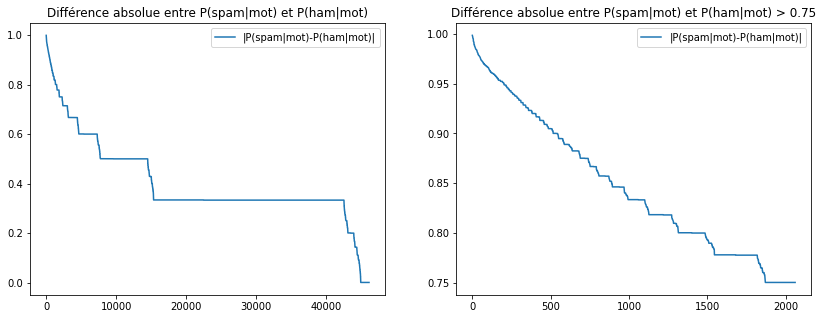

In [10]:
afficherDiff(data,0.75)

On suppose que les mots ayant une grande différence, auront plus de poids sur notre prédiction. 
On voit qu'en ne prennant que les mots ayant un taux de différence de 0.75, on réduit la taille de notre vocabulaire à près de 2000 mots. 
On va donc décider de vectoriser nos données d'apprentissage selon l'hyper-paramètre teta qui sera notre taux de différence, qui permettra de générer un vocabulaire de quelques milliers de mots plutot que 46 000.

### C) Vectorisons nos données selon notre vocabulaire

In [11]:
def vocabulaireDiff(Xa,taux):
    '''Retourne le vocabulaire selon le taux de différence '''
    V=df_proba(Xa)
    V=V[(V['diff']>taux)]
    return V.index

def vectoriser(X,vocabulaire) :
    '''Retourne X : les données vectorisées selon les mots du vocabulaire '''
    vecteurs=[]
    for mail in X.text:
        v_mail=vocabulaire_mail(mail)
        vecteur=[ int(mot in v_mail) for mot in vocabulaire]
        vecteurs.append(vecteur)
    return np.array(vecteurs)

def afficherMotdansV(X,Y) :
    '''Affiche le nombre de mots dans X selon notre vocabulaire 
    et retourne le nombre de mails pour lesquels aucun mot fait parti du vocabulaire'''
    plt.figure(figsize=(25,4))
    plt.title('Nombre de mails ayant n mots du vocabulaire')
    x=list(range(X.shape[0]))
    sns.countplot(x=np.sum(X,axis=1))
    nb=len([ mail for mail in X if np.sum(mail)==0]) #mails pour lequels 0 mots sont dans V
    return nb,len(x)

def split_et_vectorise(data,taux):
    '''Retourne Xa,Xt,Ya,Yt split aléatoirement et vectorisé selon le vocabulaire
    determiner par le taux de différence dans Xa'''
    Xa,Xt,Ya,Yt=train_test_split(data,data.label_num, test_size=0.2,shuffle=True)
    V=vocabulaireDiff(Xa,taux)
    #Vectorisons
    Xa=vectoriser(Xa,V)
    Xt=vectoriser(Xt,V)
    Ya=np.array(Ya)
    Yt=np.array(Yt)
    return Xa,Xt,Ya,Yt



v=vocabulaireDiff(data,0.75)
print(f'Longueur du vecteur : {len(v)}')



Longueur du vecteur : 2061


# 3.Apprentissage 

#### Différencions les données d'apprentissage et de test.


26 mails sur 1035 qui n'ont aucun mot du vocabulaire, ce qui est acceptable : 2.51%
Taille de notre vecteur : 5974


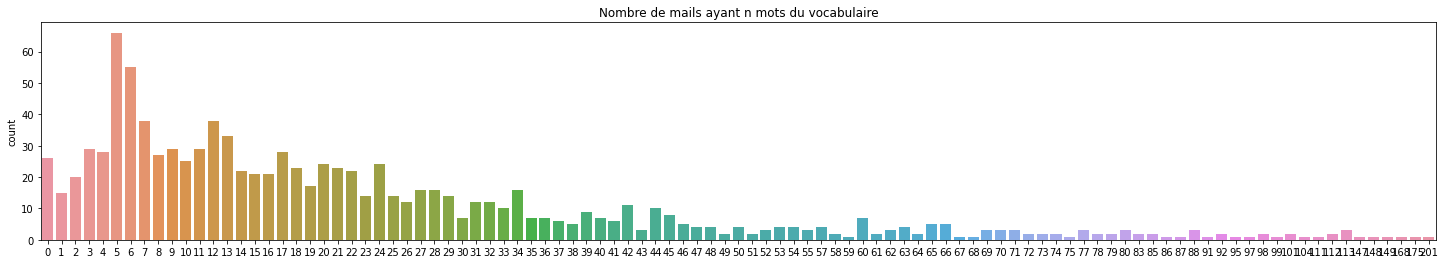

In [12]:
taux=0.585 #hyper paramètre, influence la longueur du vocabulaire
Xa,Xt,Ya,Yt=split_et_vectorise(data,taux)
nb,total=afficherMotdansV(Xt,Yt)
print(f'{nb} mails sur {total} qui n\'ont aucun mot du vocabulaire, ce qui est acceptable : {round(100*nb/total,2)}%')
print(f'Taille de notre vecteur : {Xa.shape[1]}')

### A) Gaussian model

In [13]:
def predict_Gaussian_model(Xa,Xt,Ya,Yt):
    '''Retourne la prediction de Xt et le score selon le model Bayes Naif Gaussien '''
    model=GaussianNB()
    model.fit(Xa,Ya)
    score = model.score(Xt,Yt)
    predict = model.predict(Xt)
    proba=model.predict_proba(Xt)
    return predict,score,proba

predict_G,score_G,proba_G=predict_Gaussian_model(Xa,Xt,Ya,Yt)
M_G=confusion_matrix(Yt,predict_G)
print(f'Score : {score_G}')
print(classification_report(Yt,predict_G,target_names=["Ham","Spam"]))
print(f'Matrice de confusion:\n {M_G}')


 

Score : 0.9304347826086956
              precision    recall  f1-score   support

         Ham       0.92      0.99      0.95       752
        Spam       0.98      0.76      0.86       283

    accuracy                           0.93      1035
   macro avg       0.95      0.88      0.91      1035
weighted avg       0.93      0.93      0.93      1035

Matrice de confusion:
 [[747   5]
 [ 67 216]]


### B) Bernoulli model

In [14]:
def predict_Bernoulli_model(Xa,Xt,Ya,Yt):
    '''Retourne la prediction de Xt et le score selon le model Bayes Naif Bernoulli '''
    model=BernoulliNB()
    model.fit(Xa,Ya)
    score = model.score(Xt,Yt)
    predict = model.predict(Xt)
    proba=model.predict_proba(Xt)
    return predict,score,proba
predict_B,score_B,proba_B=predict_Bernoulli_model(Xa,Xt,Ya,Yt)
M_B=confusion_matrix(Yt,predict_B)
print(f'Score : {score_B}')
print(classification_report(Yt,predict_B,target_names=["Ham","Spam"]))
print(f'Matrice de confusion:\n {M_B}')



Score : 0.9555555555555556
              precision    recall  f1-score   support

         Ham       0.95      0.99      0.97       752
        Spam       0.97      0.86      0.91       283

    accuracy                           0.96      1035
   macro avg       0.96      0.93      0.94      1035
weighted avg       0.96      0.96      0.95      1035

Matrice de confusion:
 [[745   7]
 [ 39 244]]


### C) Notre modèle

##### Démonstration de la formule utilisée.

$$P\{Y=c|X=x\}= \frac{P\{Y=c\}*P\{X=x|Y=c\}}{P\{X=x\}}$$

Par exemple pour un vecteur de longueur n :$$p_{spam|(x_0,x_1,...,x_n)} = \frac{p_{spam}.\prod\limits_{i=1}^n p_{xi|spam}}{p_{spam}.\prod\limits_{i=1}^n p_{xi|spam}+p_{ham}.\prod\limits_{i=1}^n p_{xi|ham}}$$

Passage à l'inverse :$$\frac{1}{p_{spam|(x_0,x_1,...,x_n)}} = \frac{p_{spam}.\prod\limits_{i=1}^n p_{xi|spam}+p_{ham}.\prod\limits_{i=1}^n p_{xi|ham}}{p_{spam}.\prod\limits_{i=1}^n p_{xi|spam}} $$

On soustrait 1: $$\frac{1}{p_{spam|(x_0,x_1,...,x_n)}} - 1 = \frac{p_{ham}.\prod\limits_{i=1}^n p_{xi|ham}}{p_{spam}.\prod\limits_{i=1}^n p_{xi|spam}} $$

Passage au log: $$z:= ln({\frac{1}{p_{spam|(x_0,x_1,...,x_n)}} - 1}) = ln(p_{ham})+\sum_{i=1}^n ln({p_{xi|ham}})-ln(p_{spam})-\sum_{i=1}^n ln({p_{xi|spam}})$$

Donc $$p_{spam|(x_0,x_1,...,x_n)}= \frac{1}{1+e^z}$$


In [15]:
def bernoulli(X,p):
    '''Retourne P(X=x), X qui suit une loi de Bernoulli de paramètre p'''
    return p**X*(1-p)**(1-X)

def P_X_Y_Bernoulli(X,mu):
    '''Retourne la somme des log de p(X|Y) selon le taux de xi'''
    P=[]
    for i in range(mu.size):
        #on applique bernoulli a toute la colonne du mot i de parametre mu[i]
        P.append(bernoulli(X[:,i],mu[i]))
    P=np.array(P).transpose()
    P_log=np.log(P)
    P_somme_log=np.sum(P_log,axis=1)
    return P_somme_log


def predict_Notre_model(Xa,Xt,Ya,Yt):
    '''Retourne la prediction de Xt et le score selon notre modèle
    calculs réalisés matriciellement avec numpy'''   
    
    spams=Xa[np.where(Ya==1)]
    hams=Xa[np.where(Ya==0)]
    
    #P(Y) a priori / priors
    P_S=math.log(spams.shape[0]/Xa.shape[0])  
    P_H=math.log(hams.shape[0]/Xa.shape[0])   
        
    #Calculons les paramètres qui maximise la vraisemblance p(xi|Y) 
    #taux de xi|yi avec lissage / MLE : Maximum-Likelihood-Estimates 
    mu_S=lissage_Laplace(np.sum(spams,axis=0),spams.shape[0],2)
    mu_H=lissage_Laplace(np.sum(hams,axis=0),hams.shape[0],2)
    
    #Calculons la vraisemblance xi dans classe Y selon une distribution de Bernoulli / likelihood
    P_X_S=P_X_Y_Bernoulli(Xt,mu_S).reshape(Xt.shape[0],1)
    P_X_H=P_X_Y_Bernoulli(Xt,mu_H).reshape(Xt.shape[0],1)
    
    #Calculons p(Y|xi) avec la formule démontrée : a posteriori / posterior 
    P_S_X=1/(1+np.exp(P_H+P_X_H-P_S-P_X_S))
    P_H_X=1/(1+np.exp(P_S+P_X_S-P_H-P_X_H))
    prediction_proba=np.concatenate((P_H_X,P_S_X),axis=1)
       
    #Calcul prédiction et score
    prediction= [ int(p_s>p_h) for p_h,p_s in prediction_proba]
    score= sum([ int(prediction[i]==Yt[i]) for i in range(len(Yt))])/len(Yt)  
    
    return prediction,score,prediction_proba#,prediction1,score1,prediction_proba1
    
       
predict_NB,score_NB,proba_NB=predict_Notre_model(Xa,Xt,Ya,Yt)

M_NB=confusion_matrix(Yt,predict_NB)
#M_NG=confusion_matrix(Yt,predict_NG)
print(f'Score : {score_NB}')
print(classification_report(Yt,predict_NB,target_names=["Ham","Spam"]))
print(f'Matrice de confusion:\n {M_NB}')



        

    

Score : 0.9555555555555556
              precision    recall  f1-score   support

         Ham       0.95      0.99      0.97       752
        Spam       0.97      0.86      0.91       283

    accuracy                           0.96      1035
   macro avg       0.96      0.93      0.94      1035
weighted avg       0.96      0.96      0.95      1035

Matrice de confusion:
 [[745   7]
 [ 39 244]]


### D) Comparaison 

#### Scores 

In [16]:
print("    Matrices de confusion         Scores                    Modèle")
print("--------------------------------------------------------------------------------")
print(f'{M_G}                    {score_G}          Gaussian ')
print("--------------------------------------------------------------------------------")
print(f'{M_B}                    {score_B}          Bernoulli ')
print("--------------------------------------------------------------------------------")
print(f'{M_NB}                    {score_NB}        Notre modèle Bernoulli') 
print("--------------------------------------------------------------------------------")


    Matrices de confusion         Scores                    Modèle
--------------------------------------------------------------------------------
[[747   5]
 [ 67 216]]                    0.9304347826086956          Gaussian 
--------------------------------------------------------------------------------
[[745   7]
 [ 39 244]]                    0.9555555555555556          Bernoulli 
--------------------------------------------------------------------------------
[[745   7]
 [ 39 244]]                    0.9555555555555556        Notre modèle Bernoulli
--------------------------------------------------------------------------------


Notre score est identique à celui de scikit-learn, verifions sur les probabilités données par predict_proba.

#### Probabilités

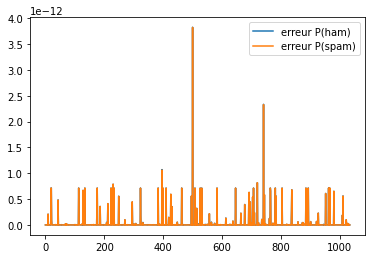

In [17]:
def afficherProba(proba_B,proba_NB):
    '''Affiche en valeur absolue la différence entre predict_proba de deux modèles'''
    plt.figure()
    I=list(range(proba_B.shape[0]))
    plt.plot(I, abs(proba_B[:,0]-proba_NB[:,0]),label="erreur P(ham)")
    plt.plot(I, abs(proba_B[:,1]-proba_NB[:,1]),label="erreur P(spam)")
    plt.legend()
afficherProba(proba_B,proba_NB)

Les erreurs de probabilités sont inférieures à $10^{-12}$, notre modèle est donc très proche de celui de Sklearn, et devrait retourner le même score. Vérifions sur plusieurs exemples et en modifiant la longueur de notre vecteur.

### E) Plus de tests et influence de notre hyper-paramètre 

In [18]:
def vocabulaireDiff_trie(Xa,taux):
    '''Retourne le vocabulaire selon le taux de différence et le dataframe trié
    utilisé seulement pour des tests'''
    V=df_proba(Xa)
    V=V[(V['diff']>taux)].sort_index(by=['diff'],ascending=False) 
    return V.index,V

def split_et_vectorise_trie(data,taux):
    '''Retourne Xa,Xt,Ya,Yt split aléatoirement et vectorisé selon le vocabulaire trié
    determiner par le taux de différence dans Xa'''
    Xa,Xt,Ya,Yt=train_test_split(data,data.label_num, test_size=0.2,shuffle=True)
    V,df=vocabulaireDiff_trie(Xa,taux)
    #Vectorisons
    Xa=vectoriser(Xa,V)
    Xt=vectoriser(Xt,V)
    Ya=np.array(Ya)
    Yt=np.array(Yt)
    return Xa,Xt,Ya,Yt,df

def reduitVecteur(Xa,Xt,df,new_taux):
    '''Reduit le vecteur selon le taux de diff et le dataframe de taux déja trié'''
    new_df=df[(df['diff']>=new_taux)]
    n=len(new_df.index)
    return Xa[:,:n],Xt[:,:n],new_df


def comparaison_taux(I,nb):
    '''Retourne une liste de score sur l intervalle I de taux de diff
    et avec nb<=lg(I) scores sur le même split'''
    G,B,N,taux,lg= [],[],[],[],[]
    taux_depart,taux_fin=I
    pas=int((taux_fin-taux_depart)//nb)
    Xa,Xt,Ya,Yt,df=split_et_vectorise_trie(data,taux_depart/100)
    for t in range(taux_depart,taux_fin+1,pas):
        Xa,Xt,df=reduitVecteur(Xa,Xt,df,t/100)
        #predictions
        _,score_G,_=predict_Gaussian_model(Xa,Xt,Ya,Yt)
        _,score_B,_=predict_Bernoulli_model(Xa,Xt,Ya,Yt)
        _,score_N,_=predict_Notre_model(Xa,Xt,Ya,Yt)
        #maj resultats
        lg.append(Xa.shape[1])
        G.append(score_G)
        B.append(score_B)
        N.append(score_N)
        taux.append(t/100) #taux et longueur du vecteur
    return G,B,N,taux,lg


def afficherCV(test):
    '''Affiche sur la même grille n lignes et 2 colonnes
    une liste de comparaison_taux de longueur n>1'''
    fig, axs = plt.subplots(len(test),2)
    fig.set_figheight(len(test)*3)
    fig.set_figwidth(10)
    for i in range(len(test)):
        G,B,N,taux,lg=test[i]
        axs[i,0].plot(taux,G ,'r:', label="Gaussien")
        axs[i,0].plot(taux,B,label="Bernoulli")
        axs[i,0].plot(taux, N,label="Notre modele")
        axs[i,0].set_title(f'epoch {i+1}')
        axs[i,0].set_ylabel('score')
        axs[i,0].set_xlabel('taux')
        axs[i,0].legend(bbox_to_anchor=(-0.1, 1.05))
        axs[i,1].plot(taux, lg,label="Longueur du vecteur")
        axs[i,1].set_xlabel('taux')
        axs[i,1].set_title(f'epoch {i+1}')
        axs[i,1].legend()
    fig.tight_layout()


In [20]:
! wget "https://raw.githubusercontent.com/morganLantrade/Projets_machine_learning/main/Projet_anti-spam/tests_saved.py"

--2022-04-02 05:25:26--  https://raw.githubusercontent.com/morganLantrade/Projets_machine_learning/main/Projet_anti-spam/tests_saved.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42972 (42K) [text/plain]
Saving to: ‘tests_saved.py’

tests_saved.py      100%[===================>]  41.96K  --.-KB/s    in 0.01s   

2022-04-02 05:25:27 (3.79 MB/s) - ‘tests_saved.py’ saved [42972/42972]



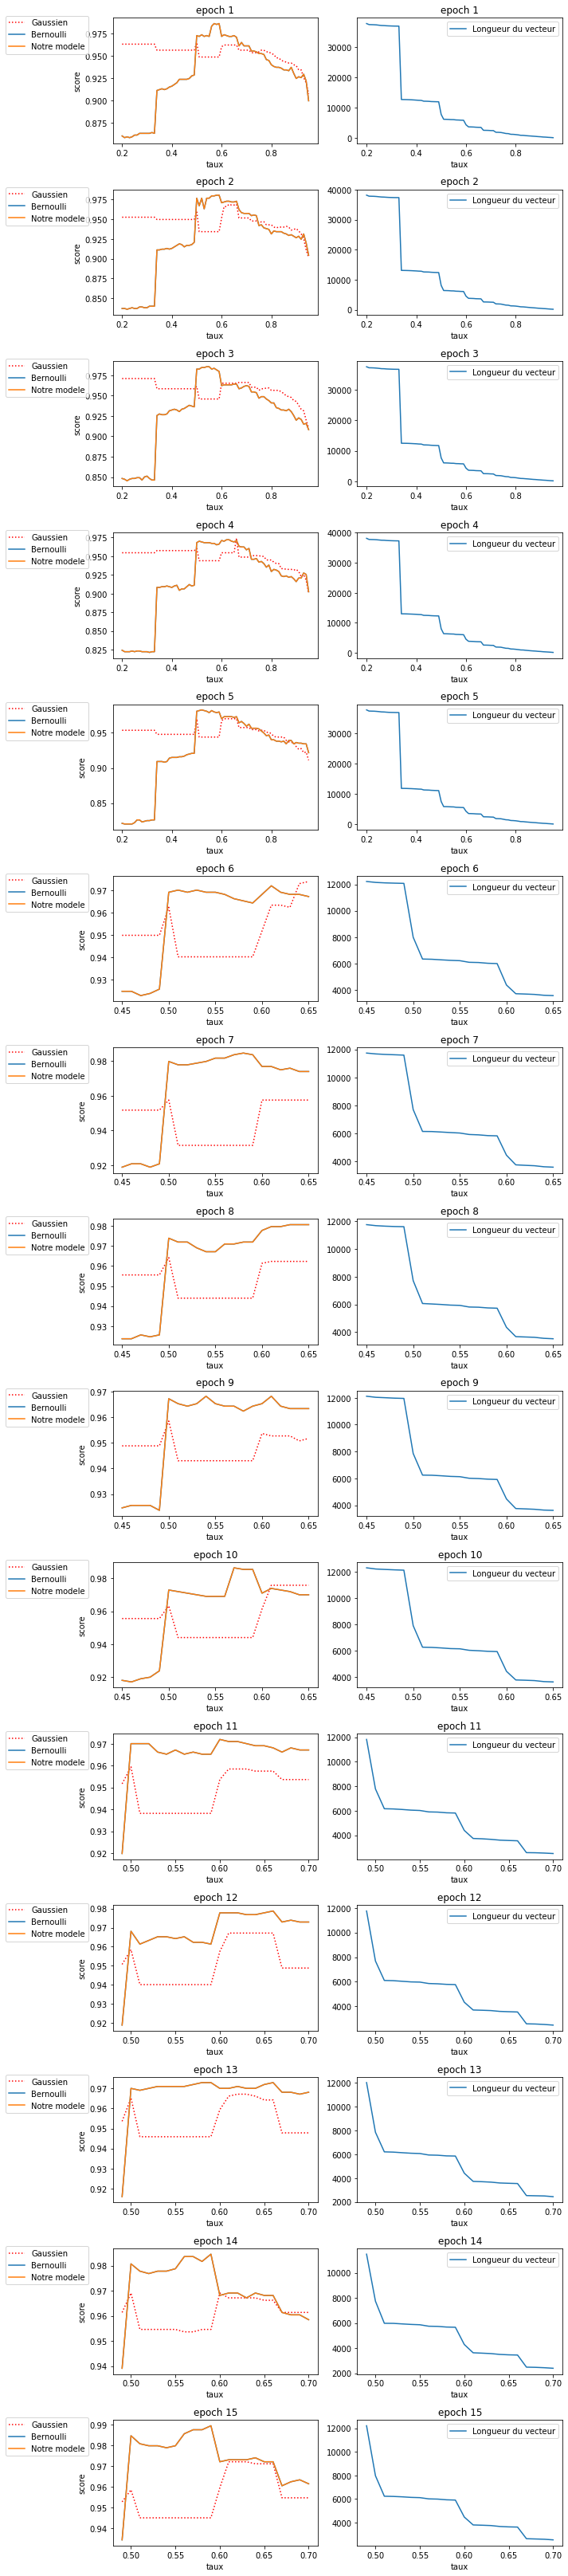

In [22]:
from tests_saved import test0,test1,test2

#test= [(comparaison_taux([55,65],10)) for _ in tqdm(range(2))]

afficherCV(test0+test1+test2)


Notre score est identique à celui de scikit-learn.
  
On remarque que le choix de notre hyper-paramètre qui determine notre vocabulaire influence le score, mais il influence aussi le calcul. Le modèle Gaussien de scikit-learn semble être moins influencé.

# Pour aller plus loin

Regardons si la longueur du mail a une influence sur le fait qu'il soit un spam ou un ham.

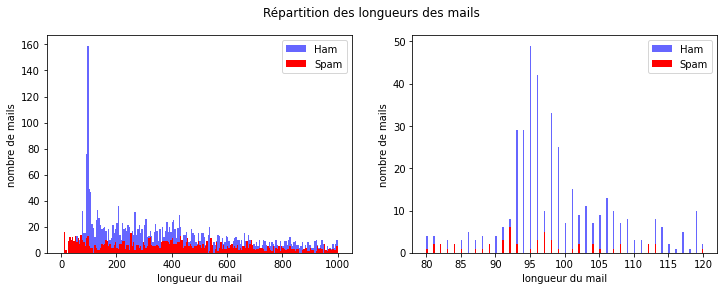

In [23]:
longueurs = [len(mail) for mail in data.text]
data['longueur']=longueurs
x=np.array(data[data.label_num==0].longueur)
y=np.array(data[data.label_num==1].longueur)
fig=plt.figure(figsize=(12,4))
# première colonne
plt.subplot(1,2,1)
ax1=plt.hist(x,bins=200, range = (0, 1000),color = 'blue',alpha=0.6,
            label = 'Ham')
ax1+=plt.hist(y,bins=200, range = (0, 1000),color = 'red',alpha=1,
            label = 'Spam')
plt.ylabel('nombre de mails')
plt.xlabel('longueur du mail')
plt.legend()
# deuxieme colonne
plt.subplot(1,2,2)
ax2=plt.hist(x,bins=200, range = (80, 120),color = 'blue',alpha=0.6,
            label = 'Ham')
ax2+=plt.hist(y,bins=200, range = (80, 120),color = 'red',alpha=1,
            label = 'Spam')
plt.ylabel('nombre de mails')
plt.xlabel('longueur du mail')
plt.legend()
fig.suptitle('Répartition des longueurs des mails')
plt.show()

Il semblerait que pour des mails de longueur comprise entre 90 et 110 caractères, il y ait une forte probabilité qu'il soit un ham.